# Helpful functions

In [6]:
import numpy as np
import os
import scipy
import tqdm

In [8]:
# Crawl the data directory
def get_data_files(data_dir = r'..\data\baseline', n_networks = 10):

    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')])
    
    all_x = []
    all_y = []

    # loop over the files
    for f in data_files[:n_networks]:
        print(f)
        data = scipy.io.loadmat(f)
        all_x.append(data['test_x'])
        all_y.append(data['test_out'])

    return np.array(all_x), np.array(all_y)

In [9]:
def make_y_pred_labels(All_network_y):
    '''Y_labels using the average of last 50 test_outs'''
    
    y_last_50_avg = All_network_y[:, :, :, -50:]
    y_last_50_avg = np.average(y_last_50_avg, axis=3)
    y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)

    # for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
    y_last_50_avg[y_last_50_avg > 0] = 1
    y_last_50_avg[y_last_50_avg < 0] = -1

    return y_last_50_avg

In [10]:
def collapse_x_by_avg_neurons(All_network_X, n_networks):
    x_nuron_avg = np.average(All_network_X, axis=3)
    x_nuron_avg = x_nuron_avg.reshape(n_networks, 4*50, 300)

    return x_nuron_avg

### Finally make the data

In [5]:
# Loading all the data
all_x, all_y = get_data_files(r'data/experimental', 10)
all_x.shape, all_y.shape

data/experimental/Osc_noise_Mod_N_10_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_18_005638_trials.mat
data/experimental/Osc_noise_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_182206_trials.mat
data/experimental/Osc_noise_Mod_N_5_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_234437_trials.mat
data/experimental/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_183033_trials.mat


((4, 4, 50, 200, 300), (4, 4, 50, 300))

In [11]:
# Helpful labels to plot later
true_labels = np.array([[1]*50 + [0]*100 + [1]*50]*4)
model_labels = ["10", "1", "5", "None"]
model_labels_exp = ["10"]*200 + ["1"]*200 + ["5"]*200 + ["None"]*200 
class_labels = ["pos pos", "pos neg", "neg pos", "neg neg"]

# Cheking which are well trained and which are messed up

In [7]:
data_dir = r'data/baseline_meta'
# data_dir = r'data/experimental_meta'

data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')])
data_files

['data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_114930.mat',
 'data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_125454.mat',
 'data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_164953.mat',
 'data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_201232.mat']

In [8]:
# loop over the files
for f in data_files:
    data = scipy.io.loadmat(f)
    print(data["tr"], f)

[[9901]] data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_114930.mat
[[10601]] data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_125454.mat
[[17301]] data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_164953.mat
[[11501]] data/baseline_meta/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_201232.mat


array([[9901]])

# Cleaned baseline and noise changes

`Lets check the data that we have till now:`

In [12]:
all_x.shape, all_y.shape

((4, 4, 50, 200, 300), (4, 4, 50, 300))

that is `4 models x 4 classes x 50 samples x 200 neurons x 300 timesetps`
To simplify our calculations, lets average the neurons and bring it to the format of `models x samples x timesteps`

In [13]:
x_prep = np.average(all_x, axis = 3).reshape(4, -1, 300)
y_prep = make_y_pred_labels(all_y)
x_prep.shape, y_prep.shape

((4, 200, 300), (4, 200))

### Various Classical Distances

In [48]:
from inspector import ModelByModel

> `Supported: ` <br>
> `    - l1: Manhattan distance` <br>
> `    - l2: Euclidean distance` <br>
> `    - minkowski: Minkowski distance` <br>
> `    - cosine: Cosine similarity` <br>
> `    - correlation: Correlation coefficient` <br>
> `    - chebyshev: Chebyshev distance` <br>
> `    - braycurtis: Bray-Curtis distance` <br>
> `    - canberra: Canberra distance` <br>
> `    - nan_euclidean: Euclidean distance with NaNs` <br>
> `    - esm: NetRep` <br>
> `    - gsm: NetRep` <br>

In [49]:
metric = ModelByModel(x_prep, y_prep, verbose=False)
distances = metric.score(metric = ["l2", "gsm", "esm", "l1", "minkowski", "cosine", "correlation", "chebyshev", "braycurtis", "canberra", "nan_euclidean"])

100%|██████████| 11/11 [03:49<00:00, 20.90s/it]


In [54]:
distances = np.array(distances)

In [55]:
# np.save("distances_baseline.npy", distances)

In [61]:
norm_dist = [x/np.max(x) for x in distances]

In [62]:
norm_dist = np.array(norm_dist)
norm_dist.shape

(11, 4, 4)

In [56]:
all_dists_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
fig_baseline_dir = r'figs/baseline'

labels = [1, 2, 3, 4]
for i, metric in enumerate(all_dists_lbls):

    fig = plt.figure(figsize=(7, 7))

    ax = sns.heatmap(norm_dist[i], cmap='Blues_r', annot=False, fmt=".2f", 
                    xticklabels=labels, yticklabels=labels, square=True, cbar=True, cbar_kws={"shrink": .8})

    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    ax.set_title("(dis)similarity in baseline models with " + metric)
    # Save the figure
    plt.savefig(fig_baseline_dir+"/baseline_" + metric + ".png", dpi=300, bbox_inches='tight')

## Comparing the similarities of the distances from various metrics

In [76]:
all_dists = np.array(distances)
all_dists_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]
all_dists.shape

(11, 4, 4)

In [77]:
metric = Classical()
ingestion_report = metric.ingest(all_dists, None)
digestion_report = metric.digest()
correlation_distance = metric.score(metric="correlation")
correlation_distance.shape

Successfully digested data, available in self.data['digested_networks']


(11, 11)

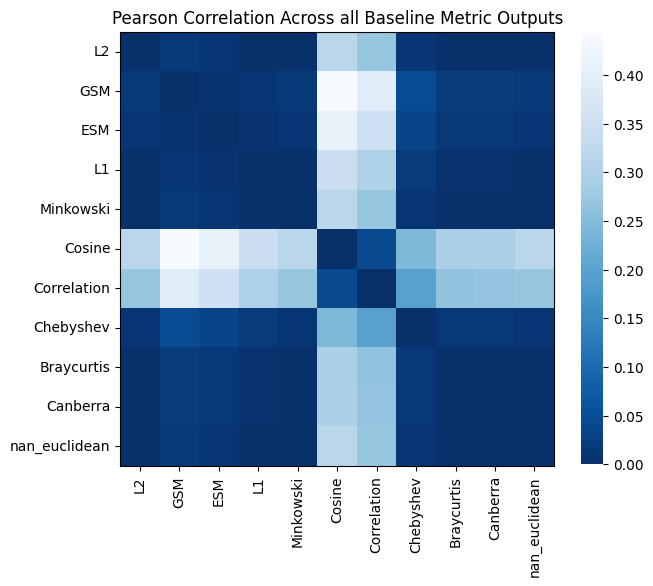

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))

ax = sns.heatmap(correlation_distance, cmap='Blues_r', annot=False, fmt=".2f", 
                 xticklabels=all_dists_lbls, yticklabels=all_dists_lbls, square=True, cbar=True, cbar_kws={"shrink": .8})

ax.set_title("Pearson Correlation Across all Baseline Metric Outputs")

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig(fig_baseline_dir+"/baseline_" + "meta" + ".png", dpi=300, bbox_inches='tight')

In [104]:
t1 = np.concatenate([correlation_distance[:5],correlation_distance[7:]])
t2 = np.concatenate([t1[:, :5], t1[:, 7:]], axis=1)
t2.shape

(9, 9)

In [105]:
l1 = all_dists_lbls[:5] + all_dists_lbls[7:]

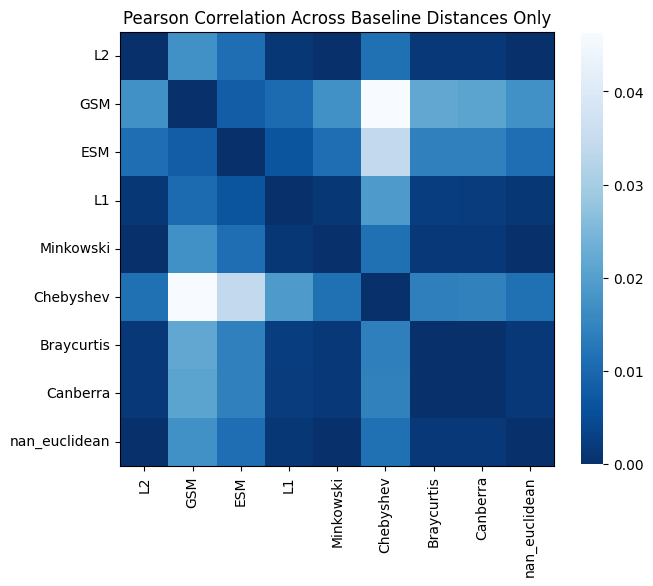

In [106]:
fig = plt.figure(figsize=(7, 7))

ax = sns.heatmap(t2, cmap='Blues_r', annot=False, fmt=".2f", 
                 xticklabels=l1, yticklabels=l1, square=True, cbar=True, cbar_kws={"shrink": .8})

ax.set_title("Pearson Correlation Across Baseline Distances Only")

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig(fig_baseline_dir+"/baseline_" + "met_only_distances" + ".png", dpi=300, bbox_inches='tight')

# Now same for Experimental

In [9]:
# Loading all the data
all_x, all_y = get_data_files(r'data/experimental', 10)
all_x.shape, all_y.shape

data/experimental/Osc_noise_Mod_N_10_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_18_005638_trials.mat
data/experimental/Osc_noise_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_182206_trials.mat
data/experimental/Osc_noise_Mod_N_5_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_234437_trials.mat
data/experimental/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_183033_trials.mat


((4, 4, 50, 200, 300), (4, 4, 50, 300))

In [108]:
all_x.shape, all_y.shape
x_prep = np.average(all_x, axis = 3).reshape(4, -1, 300)
y_prep = make_y_pred_labels(all_y)
x_prep.shape, y_prep.shape
### Various Classical Distances
from inspector import ModelByModel
metric = ModelByModel(x_prep, y_prep, verbose=False)
distances = metric.score(metric = ["l2", "gsm", "esm", "l1", "minkowski", "cosine", "correlation", "chebyshev", "braycurtis", "canberra", "nan_euclidean"])

100%|██████████| 11/11 [02:30<00:00, 13.72s/it]


In [129]:
transp_distances = [x[:, [0,2,1,3]][[0,2,1,3],:] for x in distances]
transp_distances = np.array(transp_distances)
labels = [10, 5, 1, None]

In [130]:
# np.save("distances_baseline.npy", distances)
norm_dist = [x/np.max(x) for x in transp_distances]
norm_dist = np.array(norm_dist)
norm_dist.shape

(11, 4, 4)

In [ ]:
all_dists_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]
import seaborn as sns
import matplotlib.pyplot as plt
fig_experimental_dir = r'figs/experimental'

for i, metric in enumerate(all_dists_lbls):

    fig = plt.figure(figsize=(7, 7))

    ax = sns.heatmap(norm_dist[i], cmap='Blues_r', annot=False, fmt=".2f", 
                    xticklabels=labels, yticklabels=labels, square=True, cbar=True, cbar_kws={"shrink": .8})

    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    ax.set_title("(dis)similarity in experimental models with " + metric)
    # Save the figure
    plt.savefig(fig_experimental_dir+"/experimental_" + metric + ".png", dpi=300, bbox_inches='tight')

In [ ]:
## Comparing the similarities of the distances from various metrics
all_dists = np.array(transp_distances)
all_dists_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]
all_dists.shape
metric = Classical()
ingestion_report = metric.ingest(all_dists, None)
digestion_report = metric.digest()
correlation_distance = metric.score(metric="correlation")
correlation_distance.shape
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))

ax = sns.heatmap(correlation_distance, cmap='Blues_r', annot=False, fmt=".2f", 
                 xticklabels=all_dists_lbls, yticklabels=all_dists_lbls, square=True, cbar=True, cbar_kws={"shrink": .8})

ax.set_title("Pearson Correlation Across all Experimental Metric Outputs")

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig(fig_experimental_dir+"/experimental_" + "meta" + ".png", dpi=300, bbox_inches='tight')
t1 = np.concatenate([correlation_distance[:5],correlation_distance[7:]])
t2 = np.concatenate([t1[:, :5], t1[:, 7:]], axis=1)
t2.shape
l1 = all_dists_lbls[:5] + all_dists_lbls[7:]
fig = plt.figure(figsize=(7, 7))

ax = sns.heatmap(t2, cmap='Blues_r', annot=False, fmt=".2f", 
                 xticklabels=l1, yticklabels=l1, square=True, cbar=True, cbar_kws={"shrink": .8})

ax.set_title("Pearson Correlation Across Experimental Distances Only")

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig(fig_experimental_dir+"/experimental_" + "met_only_distances" + ".png", dpi=300, bbox_inches='tight')

# Combining all the models together

In [3]:
import os

In [4]:
data_dir = r'data/baseline'
sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')])

['data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_114930_trials.mat',
 'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_125454_trials.mat',
 'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_164953_trials.mat',
 'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_201232_trials.mat']

In [5]:
data_dir = r'data/experimental'
sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')])

['data/experimental/Osc_noise_Mod_N_10_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_18_005638_trials.mat',
 'data/experimental/Osc_noise_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_182206_trials.mat',
 'data/experimental/Osc_noise_Mod_N_5_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_234437_trials.mat',
 'data/experimental/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_183033_trials.mat']

In [12]:
# Crawl the data directory
def get_data_files(n_networks = 10):

    data_files = [
        'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_114930_trials.mat',
        'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_125454_trials.mat',
        'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_164953_trials.mat',
        'data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_201232_trials.mat',

        'data/experimental/Osc_noise_Mod_N_10_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_18_005638_trials.mat',
        'data/experimental/Osc_noise_Mod_N_5_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_234437_trials.mat',
        'data/experimental/Osc_noise_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_182206_trials.mat',
        'data/experimental/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_183033_trials.mat'
        ]
    
    all_x = []
    all_y = []

    # loop over the files
    for f in data_files[:n_networks]:
        print(f)
        data = scipy.io.loadmat(f)
        all_x.append(data['test_x'])
        all_y.append(data['test_out'])

    return np.array(all_x), np.array(all_y)

In [13]:
# Loading all the data
all_x, all_y = get_data_files(10)
all_x.shape, all_y.shape

x_prep = np.average(all_x, axis = 3).reshape(8, -1, 300)
y_prep = make_y_pred_labels(all_y)
x_prep.shape, y_prep.shape

data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_114930_trials.mat
data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_125454_trials.mat
data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_164953_trials.mat
data/baseline/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_201232_trials.mat
data/experimental/Osc_noise_Mod_N_10_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_18_005638_trials.mat
data/experimental/Osc_noise_Mod_N_5_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_234437_trials.mat
data/experimental/Osc_noise_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_17_182206_trials.mat
data/experimental/Osc_none_Mod_N_1_Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2022_04_13_183033_trials.mat


((8, 200, 300), (8, 200))

In [19]:
type_label = ["baseline","baseline", "baseline","baseline", "experimental", "experimental", "experimental", "experimental"]
noise_label = ["None", "None", "None", "None", "10 channel(s)", "5 channel(s)", "1 channel(s)", "None"]

# Precompute

In [20]:
### Various Classical Distances
from inspector import ModelByModel
metric = ModelByModel(x_prep, y_prep, verbose=False)
distances = metric.score(metric = ["l2", "gsm", "esm", "l1", "minkowski", "cosine", "correlation", "chebyshev", "braycurtis", "canberra", "nan_euclidean"])

100%|██████████| 11/11 [15:50<00:00, 86.38s/it]


In [21]:
np.save("all_dists.npy", distances)

In [22]:
norm_dist = [x/np.max(x) for x in distances]
norm_dist = np.array(norm_dist)
norm_dist.shape

(11, 8, 8)

In [73]:
# from netrep.multiset import pairwise_distances
# from netrep_new.metrics.stochastic import EnergyStochasticMetric
# metric = EnergyStochasticMetric()
# pairwise_distances(metric, x[0][0])
# distance = metric.pairwise_distances(x, y_prep[:4])
# distance

# MDS

In [55]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# create an instance of the MDS class
mds = MDS(dissimilarity='precomputed', normalized_stress = "auto")

# fit the MDS model to the precomputed cosine distance matrix
all_mds = []
for dist in distances:
    all_mds.append(mds.fit_transform(dist))

In [14]:
type_label = ["baseline","baseline", "baseline","baseline", "experimental", "experimental", "experimental", "experimental"]
noise_label = ["Base None", "Base None", "Base None", "Base None", "Exp 10", "Exp 5", "Exp 1", "Exp None"]
metric_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]

In [ ]:
import scprep

for i, mds in enumerate(all_mds):
    scprep.plot.scatter2d(
        mds, 
        c = noise_label, 
        figsize=(10,10), 
        title="MDS with " + metric_lbls[i] + " Distance", 
        label_prefix='MDS',
        filename="figs/mds/"+ metric_lbls[i] + ".png",
        legend_loc = "upper right"
        )

# All in one mds

In [59]:
distances = np.array(distances)
distances.shape

(11, 8, 8)

In [67]:
td = norm_dist.reshape(-1, 8)
td.shape

(88, 8)

In [ ]:
# L2, GSM, ESM, L1, Minkowski, Cosine, Correlation, Chebyshev, Braycurtis, Canberra, nan_euclidean

In [15]:
metric_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]
# Multiply every element in the above array 8 times
new_metric_lbls = np.repeat(metric_lbls, 8)
rep_type_label = np.repeat(type_label, 11)

In [69]:
new_metric_lbls

array(['L2', 'L2', 'L2', 'L2', 'L2', 'L2', 'L2', 'L2', 'GSM', 'GSM',
       'GSM', 'GSM', 'GSM', 'GSM', 'GSM', 'GSM', 'ESM', 'ESM', 'ESM',
       'ESM', 'ESM', 'ESM', 'ESM', 'ESM', 'L1', 'L1', 'L1', 'L1', 'L1',
       'L1', 'L1', 'L1', 'Minkowski', 'Minkowski', 'Minkowski',
       'Minkowski', 'Minkowski', 'Minkowski', 'Minkowski', 'Minkowski',
       'Cosine', 'Cosine', 'Cosine', 'Cosine', 'Cosine', 'Cosine',
       'Cosine', 'Cosine', 'Correlation', 'Correlation', 'Correlation',
       'Correlation', 'Correlation', 'Correlation', 'Correlation',
       'Correlation', 'Chebyshev', 'Chebyshev', 'Chebyshev', 'Chebyshev',
       'Chebyshev', 'Chebyshev', 'Chebyshev', 'Chebyshev', 'Braycurtis',
       'Braycurtis', 'Braycurtis', 'Braycurtis', 'Braycurtis',
       'Braycurtis', 'Braycurtis', 'Braycurtis', 'Canberra', 'Canberra',
       'Canberra', 'Canberra', 'Canberra', 'Canberra', 'Canberra',
       'Canberra', 'nan_euclidean', 'nan_euclidean', 'nan_euclidean',
       'nan_euclidean', 'na

In [70]:
# Do MDS on td non precomputed

# create an instance of the MDS class
mds = MDS(dissimilarity='euclidean', normalized_stress = "auto")

# fit the MDS model to the precomputed cosine distance matrix
tog_mds = mds.fit_transform(td)

In [ ]:
scprep.plot.scatter2d(
    tog_mds, 
    c = new_metric_lbls, 
    figsize=(10,10), 
    title="MDS with " + "euclidean" + " Distance", 
    label_prefix='MDS',
    # filename="figs/mds/"+ metric_lbls[i] + ".png",
    legend_loc = "best",
    )

In [ ]:
scprep.plot.scatter2d(
    tog_mds, 
    c = rep_type_label, 
    figsize=(10,10), 
    title="MDS with " + "euclidean" + " Distance", 
    label_prefix='MDS',
    # filename="figs/mds/"+ metric_lbls[i] + ".png",
    legend_loc = "best",
    )

# Generate PHATE plots

In [36]:
import phate
import scprep
%matplotlib inline
phate_operator = phate.PHATE(n_jobs=-2)

## Prep the data for PHATE

In [17]:
distances = np.load("all_dists.npy")

In [31]:
norm_dist = [x/np.max(x) for x in distances]
norm_dist = np.array(norm_dist)
norm_dist.shape

(11, 8, 8)

In [ ]:
# # Lets downsample our timesteps by a factor of 5
# sample_rate = 5
# samples = 300//sample_rate

# # Make time the Y axis the "samples" and reshape it
# x_prep = all_x.transpose(0, 1, 2, 4, 3)[:,:,:,::sample_rate,:]
# x_prep = x_prep.reshape(4, 4 * 50 *samples , 200)
# print(x_prep.shape)

(4, 12000, 200)


In [24]:
# Model with 10 noise channels
x_phate = distances[1]

In [ ]:
phate_operator.set_params(n_components=2, knn_dist='precomputed')
all_phates = []
for dist in norm_dist:
    all_phates.append(phate_operator.fit_transform(dist))

In [ ]:
import scprep

for i, phate in enumerate(all_phates):
    scprep.plot.scatter2d(
        phate, 
        c = noise_label, 
        figsize=(8,6), 
        title="PHATE with " + metric_lbls[i] + " Distance", 
        label_prefix='PHATE',
        filename="figs/phate/"+ metric_lbls[i] + ".png",
        legend_loc = "upper right"
        )

Calculating PHATE...
  Running PHATE on 88 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.07 seconds.


/home/rudra/.local/lib/python3.11/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 0 and 80, 1 and 81, 2 and 82, 5 and 85, 6 and 86, 7 and 87. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/rudra/.local/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/rudra/.local/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/rudra/.local/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'PHATE with Affinity'}, xlabel='PHATE1', ylabel='PHATE2'>

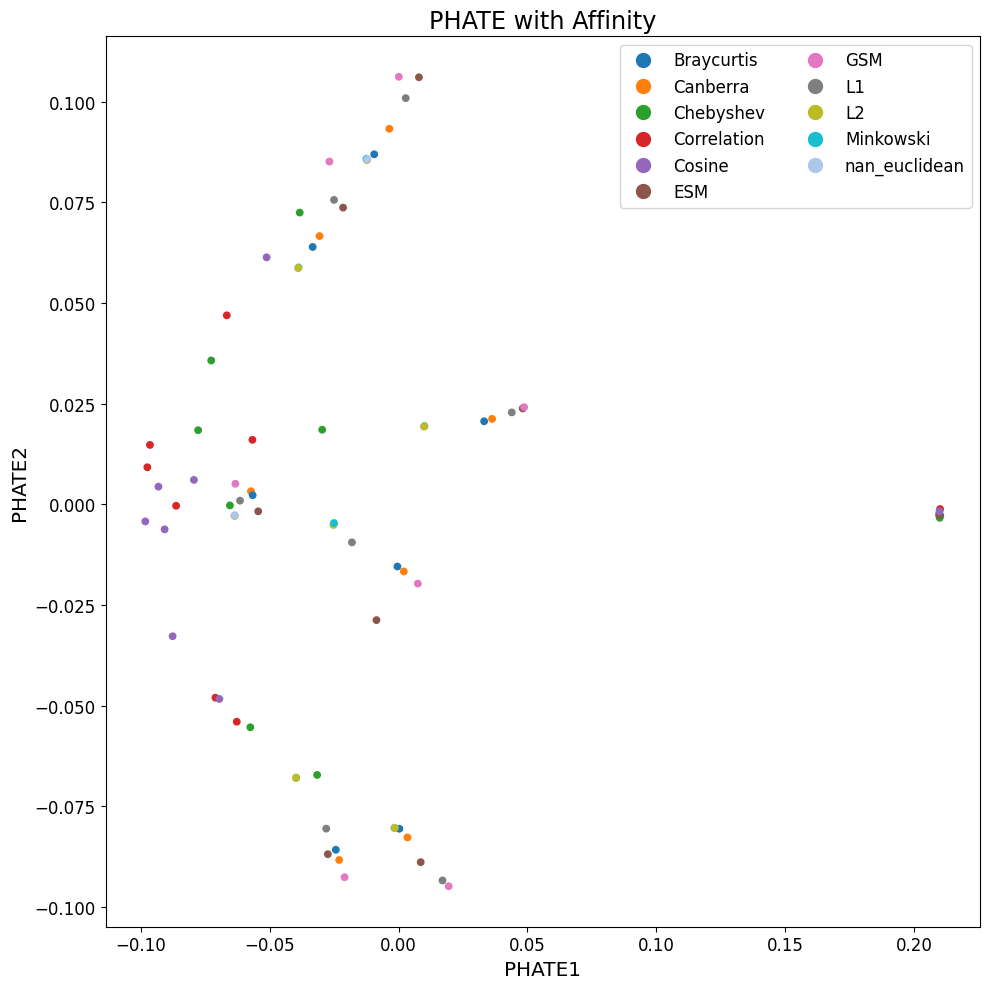

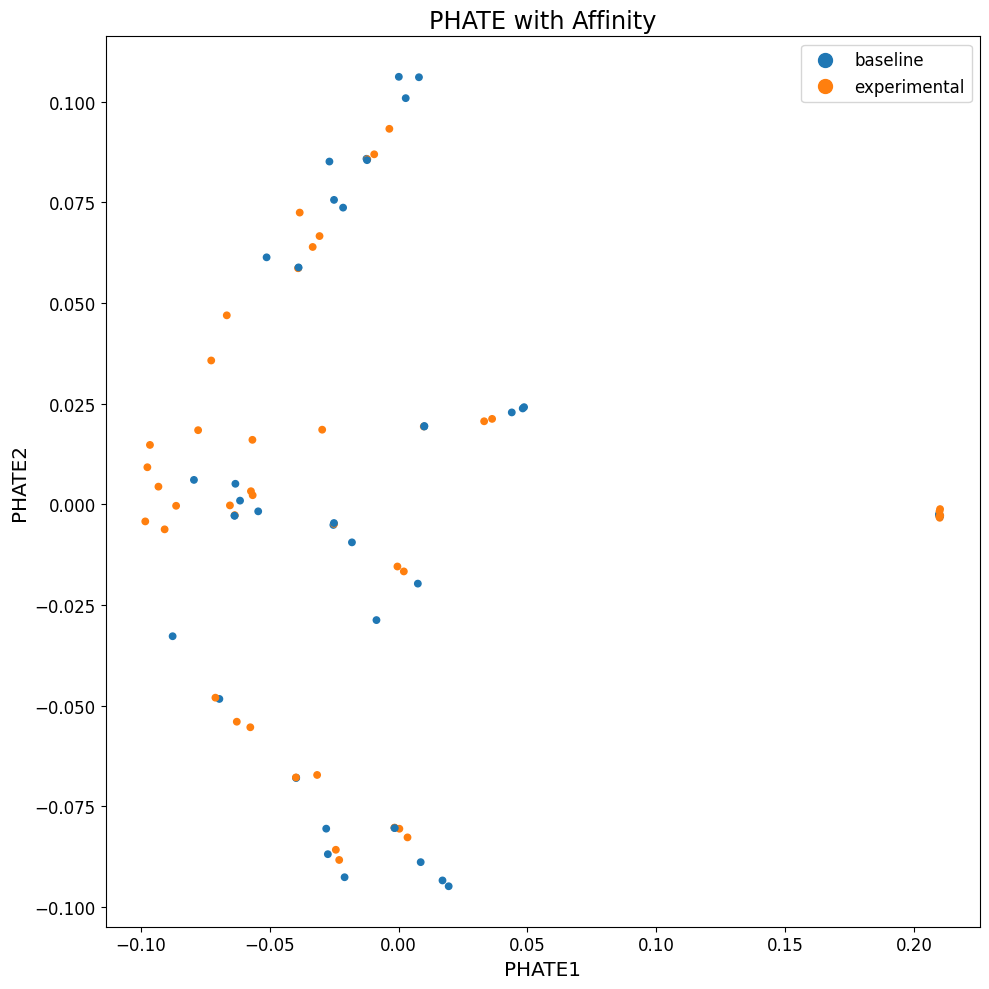

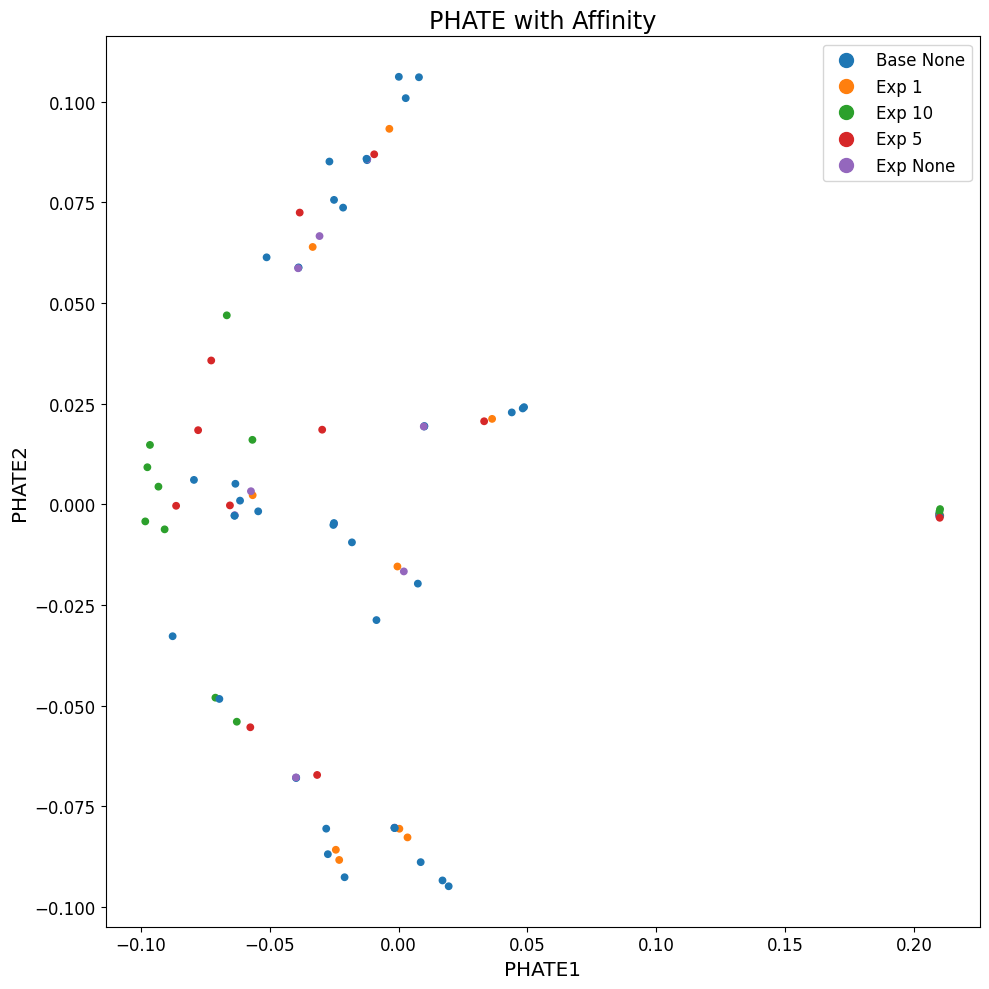

In [40]:
distances = np.array(distances)
distances.shape
td = norm_dist.reshape(-1, 8)
td.shape
metric_lbls = ["L2", "GSM", "ESM", "L1", "Minkowski", "Cosine", "Correlation", "Chebyshev", "Braycurtis", "Canberra", "nan_euclidean"]
# Multiply every element in the above array 8 times
new_metric_lbls = np.repeat(metric_lbls, 8)
rep_type_label = np.repeat(type_label, 11)

noise_label = ["Base None", "Base None", "Base None", "Base None", "Exp 10", "Exp 5", "Exp 1", "Exp None"]
rep_noise_label = np.repeat(noise_label, 11)
new_metric_lbls
# Do PHATE on td non precomputed

# create an instance of the PHATE class
# PHATE = PHATE(dissimilarity='euclidean', normalized_stress = "auto")
phate_operator = phate.PHATE(n_jobs=-2)
phate_operator.set_params(n_components=2)

# fit the PHATE model to the precomputed cosine distance matrix
tog_PHATE = phate_operator.fit_transform(td)
scprep.plot.scatter2d(
    tog_PHATE, 
    c = new_metric_lbls, 
    figsize=(10,10), 
    title="PHATE with " + "Affinity", 
    label_prefix='PHATE',
    # filename="figs/PHATE/"+ metric_lbls[i] + ".png",
    legend_loc = "best",
    )
scprep.plot.scatter2d(
    tog_PHATE, 
    c = rep_type_label, 
    figsize=(10,10), 
    title="PHATE with " + "Affinity", 
    label_prefix='PHATE',
    # filename="figs/PHATE/"+ metric_lbls[i] + ".png",
    legend_loc = "best",
    )
scprep.plot.scatter2d(
    tog_PHATE, 
    c = rep_noise_label, 
    figsize=(10,10), 
    title="PHATE with " + "Affinity", 
    label_prefix='PHATE',
    # filename="figs/PHATE/"+ metric_lbls[i] + ".png",
    legend_loc = "best",
    )